## 기본설정 및 함수정의

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

# 목표표 위도, 경도
hwasung = [37.20387682941874, 127.0634311210021]
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

#### 대상구역

In [44]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/3.대상구역도(하남교산).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
object_area_df = pd.json_normalize(geojson_data['features'])
object_area_df['geometry'] = object_area_df['geometry.coordinates'].apply(lambda x : make_pol(x))
object_area_df.drop(columns="geometry.coordinates", inplace=True)
object_area_df = gpd.GeoDataFrame(object_area_df, geometry='geometry')

##### 격자

In [5]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/2-14.하남시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df = grid_map_df[~grid_map_df['properties.gid'].str.startswith('다아')]
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')

##### 행정동

In [47]:
# 하남시 행정동 데이터
shapefile_path1 = "SBJ_2411_001/bnd_dong_31180_2023_2Q/bnd_dong_31180_2023_2Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 화성시 행정동 데이터
shapefile_path2 = "SBJ_2411_001/bnd_dong_31240_2023_2Q/bnd_dong_31240_2023_2Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path2)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

In [ ]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=object_area_df, name="대상구역 데이터")
map.add_data(data=grid_map_df, name="격자 데이터")

# 맵 출력 및 상세설정
map

#### 격자(매핑용)

In [3]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/1-14.화성시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df = grid_map_df[~grid_map_df['properties.gid'].str.startswith('다아')]
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')

In [ ]:
# 맵 객체 생성 및 데이터 로드
hwasung_map = KeplerGl(height=1000, width=1500)
hwasung_map.add_data(data=grid_map_df, name="격자 데이터")

# 맵 출력 및 상세설정
hwasung_map

In [22]:
# 맵 저장
hwasung_map.save_to_html(file_name="visualization/화성시 현황/화성시 격자 map.html")

Map saved to visualization/화성시 현황/화성시 격자 map.html!


#### 격자인구통계

In [4]:
respop_df = pd.read_csv('SBJ_2411_001/1-1.화성시_거주인구.csv')

#grid ID 리스트 와 매핑 & respop_df 필터링
grid_id = grid_map_df['properties.gid'].tolist() # gid는 전부 unique한 값
grid_respop = respop_df[respop_df['gid'].isin(grid_id)]
grid_respop = grid_respop.fillna(0)
grid_respop = pd.concat([grid_respop.iloc[:, :2], grid_respop.iloc[:, 2:].astype(int)], axis=1)
grid_respop['year'] = grid_respop['year'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['gid', 'year']
for i in range(2, len(grid_respop.columns)):
    age = f'{grid_respop.columns[i][2:4]}대' if grid_respop.columns[i][2] != '1' else f'{grid_respop.columns[i][2:5]}대'
    sex = '남' if grid_respop.columns[i][0] != 'm' else '여'
    columns.append('%s_%s'%(age, sex))
grid_respop.columns = columns
# 인구 column & 고령인구 column & 고령인구 비율(%) column 생성
grid_respop['인구'] = grid_respop.iloc[:, 2:].sum(axis=1)

In [5]:
# 연령대별로 성별 통합
grid_respop['20대'] = grid_respop['20대_여'] + grid_respop['20대_남']
grid_respop['30대'] = grid_respop['30대_여'] + grid_respop['30대_남']
grid_respop['40대'] = grid_respop['40대_여'] + grid_respop['40대_남']
grid_respop['50대'] = grid_respop['50대_여'] + grid_respop['50대_남']
grid_respop['60대'] = grid_respop['60대_여'] + grid_respop['60대_남']
grid_respop['70대'] = grid_respop['70대_여'] + grid_respop['70대_남']
grid_respop['80대'] = grid_respop['80대_여'] + grid_respop['80대_남']
grid_respop['90대'] = grid_respop['90대_여'] + grid_respop['90대_남']
grid_respop['100대'] = grid_respop['100대_여'] + grid_respop['100대_남']

# 필요한 열만 선택
age_totals = grid_respop[['year', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100대']]

# 데이터프레임을 긴 형식으로 변환
age_totals_melted = age_totals.melt(id_vars='year', var_name='Age Group', value_name='Count')

# 연도별 연령대 분포 계산
age_totals_yearly = age_totals_melted[['Age Group', 'Count']].groupby(['Age Group']).sum().reset_index()
# 100대 연령대 제거
age_totals_yearly = age_totals_yearly[age_totals_yearly['Age Group'] != '100대']

# 연령대 종합 평균내기
age_totals_yearly['Count'] = age_totals_yearly['Count'] / 4
age_totals_yearly['Count'] = age_totals_yearly['Count'].astype(int)
# 시각화
fig = px.bar(
    age_totals_yearly,
    x='Age Group',
    y='Count',
    color='Count',
    color_continuous_scale='Plasma_r',  # Plasma 색상 맵 사용
    labels={'year': 'Year', 'Count': 'Population Count', 'Age Group': 'Age Group'},
)
fig.update_layout(height=600, width=1200)
fig.show()

In [6]:
gen_respop = grid_respop[['gid', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100대', '인구']]
gen_respop = gen_respop.groupby('gid').sum().reset_index()

# 격자 ID와 격자 폴리곤 각각을 매핑한 딕셔너리 생성
map_dic = dict(zip(grid_map_df['properties.gid'], grid_map_df['geometry']))

# 생성된 map_dic에 filtered_respop의 gid를 매핑하여 'geometry' column 생성
geometry_lst = []
for _, row in gen_respop.iterrows():
    geometry_lst.append(map_dic[row['gid']])
gen_respop['geometry'] = geometry_lst
gen_respop = gpd.GeoDataFrame(gen_respop, geometry='geometry')

In [ ]:
# 맵 객체 생성 및 데이터 로드
hwasung_gridgenpop_map = KeplerGl(height=1000, width=1500)
hwasung_gridgenpop_map.add_data(data=gen_respop, name="화성시 격자거주인구 데이터")

# 맵 출력 및 상세설정
hwasung_gridgenpop_map

In [24]:
# 맵 저장
hwasung_gridgenpop_map.save_to_html(file_name="visualization/화성시 현황/화성시 격자거주인구 map.html")

Map saved to visualization/화성시 현황/화성시 격자거주인구 map.html!


In [183]:
grid_respop

,gid,year,20대_여,20대_남,30대_여,30대_남,40대_여,40대_남,50대_여,50대_남,60대_여,60대_남,70대_여,70대_남,80대_여,80대_남,90대_여,90대_남,100대_여,100대_남,인구,20대,30대,40대,50대,60대,70대,80대,90대,100대
0,다사385011,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,다사312110,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,다사473033,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,다사602117,2023,10,7,15,6,6,9,6,7,0,9,0,0,0,0,0,0,0,0,75,17,21,15,13,9,0,0,0,0
4,다사476205,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285531,다사513058,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
285532,다사553001,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
285533,다사517088,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
285534,다사456150,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
age_totals_gen = age_totals.groupby('year').sum().reset_index()
# 각 세대별 총 인구수 계산 및 정렬
total_pop = age_totals_gen.drop(columns='year').sum().sort_values(ascending=False)
sorted_columns = total_pop.index.tolist()

# 각 세대별로 데이터를 분리하여 선과 마커를 동시에 표시하는 그래프 생성
fig = go.Figure()

for column in sorted_columns:  # 'year' 열을 제외한 각 세대별 열에 대해 반복
    fig.add_trace(go.Scatter(
        x=age_totals_gen['year'], 
        y=age_totals_gen[column], 
        mode='lines+markers', 
        name=column
    ))
# 색상 업데이트
colors =px.colors.sequential.Plasma # 컬러맵
for i, trace in enumerate(fig.data):
    trace.line.color = colors[i % len(colors)]
# 그래프 레이아웃 설정
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Population',
    width=800,
    height=600
)

# 그래프 시각화
fig.show()

In [9]:
year_lst = range(2020, 2024)
year_pop = [] # 인구수 종합
for year in year_lst:
    # 해당 year의 인구수 종합
    year_pop.append(grid_respop[grid_respop['year'] == str(year)]['인구'].sum())

pop_df = pd.DataFrame({'연도':year_lst, '종합인구':year_pop})
pop_df

,연도,종합인구
0,2020,541513
1,2021,551682
2,2022,554354
3,2023,621286


In [10]:
fig = px.line(pop_df, x='연도', y='종합인구', labels={'x':'연도', 'y':'인구수'})
fig.update_traces(mode='lines+markers')

fig.update_xaxes(
        showticklabels=True, 
        showgrid=False, 
        tickmode='array',
        range=[2019.5, 2023.5],
        tickvals=[2020, 2021, 2022, 2023],  # x축에 표시할 값
        ticktext=['2020', '2021', '2022', '2023'],  # x축에 표시할 텍스트
    )
fig.update_yaxes(
    showticklabels=True, 
    showgrid=True,
    )
fig.update_layout(height=800, width=1200)
fig.show()

In [11]:
grid_pop_df = grid_respop[['gid', 'year', '인구']]
geometry_lst = []
for _, row in grid_pop_df.iterrows():
    geometry_lst.append(map_dic[row['gid']])
grid_pop_df['geometry'] = geometry_lst
grid_pop_df = grid_pop_df[grid_pop_df['인구'] != 0]
grid_pop_df = gpd.GeoDataFrame(grid_pop_df, geometry='geometry')

C:\Users\user\AppData\Local\Temp\ipykernel_22452\734192253.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# 맵 객체 생성 및 데이터 로드
hwasung_gridpop_map = KeplerGl(height=1000, width=1500)
hwasung_gridpop_map.add_data(data=grid_pop_df, name="화성시 격자거주인구 데이터")

# 맵 출력 및 상세설정
hwasung_gridpop_map

In [75]:
# 맵 저장
hwasung_gridpop_map.save_to_html(file_name="visualization/화성성시 현황/화성성시 격자거주인구 map.html")

Map saved to visualization/세종시 현황/세종시 격자거주인구 map.html!


#### 세대별 유동인구

In [184]:
floating_population_df

,year,10대,20대,30대,40대,50대,60대,pop,lon,lat,geometry
0,2020-01,0.53,1.14,1.55,1.87,2.39,2.63,8.77,126.616734,37.169078,POINT (126.61673 37.16908)
1,2020-01,0.52,1.12,1.45,1.86,2.29,2.40,8.47,126.616729,37.169528,POINT (126.61673 37.16953)
2,2020-01,0.62,1.35,1.69,2.10,2.64,2.74,9.80,126.616724,37.169979,POINT (126.61672 37.16998)
3,2020-01,0.70,1.51,1.83,2.28,2.90,2.99,10.75,126.616718,37.170430,POINT (126.61672 37.17043)
4,2020-01,0.42,1.23,1.75,2.77,3.60,3.42,11.54,126.616713,37.170880,POINT (126.61671 37.17088)
...,...,...,...,...,...,...,...,...,...,...,...
5269119,2022-12,70.58,24.42,71.33,109.11,45.58,33.80,337.37,127.111036,37.203731,POINT (127.11104 37.20373)
5269120,2022-12,14.86,4.29,11.85,19.34,7.80,5.86,61.00,127.111034,37.204182,POINT (127.11103 37.20418)
5269121,2022-12,4.12,1.38,4.17,5.96,2.48,2.00,19.05,127.111031,37.204633,POINT (127.11103 37.20463)
5269122,2022-12,12.86,7.08,7.98,11.64,8.78,3.88,50.28,127.111029,37.205083,POINT (127.11103 37.20508)


In [21]:
# 유동인구 df 로드
floating_population_df = pd.read_csv('SBJ_2411_001/1-8.화성시_성연령별_유동인구.csv')
floating_population_df['STD_YM'] = floating_population_df['STD_YM'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['year']
for i in range(1, 13):
    floating_population_df[floating_population_df.columns[i]] = floating_population_df[floating_population_df.columns[i]].astype(float)
    new_col = f'{floating_population_df.columns[i][2:4]}대_남' if floating_population_df.columns[i][0] != 'm' else f'{floating_population_df.columns[i][2:4]}대_여'
    columns.append(new_col)
floating_population_df.columns = columns + floating_population_df.columns[13:15].tolist()
floating_population_df['pop'] = floating_population_df.iloc[:, 1:-3].sum(axis=1)

# 연령대별로 성별 통합
floating_population_df['10대'] = floating_population_df['10대_남'] + floating_population_df['10대_여']
floating_population_df['20대'] = floating_population_df['20대_남'] + floating_population_df['20대_여']
floating_population_df['30대'] = floating_population_df['30대_남'] + floating_population_df['30대_여']
floating_population_df['40대'] = floating_population_df['40대_남'] + floating_population_df['40대_여']
floating_population_df['50대'] = floating_population_df['50대_남'] + floating_population_df['50대_여']
floating_population_df['60대'] = floating_population_df['60대_남'] + floating_population_df['60대_여']
flopop_df = floating_population_df[['year', 'pop'] + list(floating_population_df.columns[13:15])]
col_lst = ['year'] + list(floating_population_df.columns[1:13]) + list(floating_population_df.columns[-6:]) + ['pop'] + list(floating_population_df.columns[13:15])
floating_population_df = floating_population_df[col_lst]
# 연도 월 정보를 "YYYY-MM-DD HH:MM:SS" 형식으로 변환하는 함수
def convert_to_datetime_format(year_month_str):
    year = year_month_str[:4]
    month = year_month_str[4:6]
    return f"{year}-{month}"
# 변환 적용
floating_population_df['year'] = floating_population_df['year'].apply(convert_to_datetime_format)
floating_population_df = floating_population_df[list(floating_population_df.columns[:1]) + list(floating_population_df.columns[13:])]
floating_population_df = geo_transform(floating_population_df)

merged_gdf = gpd.sjoin(floating_population_df, grid_map_df, how='inner', op='within')
grid_time_summary = merged_gdf.groupby(['year', 'properties.gid']).agg({
    'pop': 'sum',       # 유동인구 합계
}).reset_index()
grid_dict = dict(zip(grid_map_df['properties.gid'], grid_map_df['geometry']))
grid_time_summary['geometry'] = grid_time_summary['properties.gid'].map(grid_dict)
grid_time_summary = gpd.GeoDataFrame(grid_time_summary, geometry='geometry')

100%|██████████| 5269124/5269124 [03:21<00:00, 26141.99it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Te

In [18]:
# 맵 객체 생성 및 데이터 로드
hwasung_floatingpop_map = KeplerGl(height=1000, width=1500)
hwasung_floatingpop_map.add_data(data=grid_time_summary, name="유동인구 데이터")

hwasung_floatingpop_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [19]:
# 맵 저장
hwasung_floatingpop_map.save_to_html(file_name="visualization/화성시 현황/화성시 세대별 유동인구 map.html")

Map saved to visualization/화성시 현황/화성시 세대별 유동인구 map.html!


#### 공유차량 이용현황

In [130]:
sharecar_df = pd.read_csv('SBJ_2411_001/1-11.화성시_공유차량_이용현황.csv')
cols_to_exclude = ['car_type', 'car_cnt', 'car_type']  # 제외할 열
columns_to_fill = [col for col in sharecar_df.columns if col not in cols_to_exclude]
sharecar_df[columns_to_fill] = sharecar_df[columns_to_fill].fillna(0)
sharecar_df['car_type'] = sharecar_df['car_type'].fillna("")

from sklearn.linear_model import LinearRegression

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])  # 세 열 모두 값이 있는 데이터
test_data = sharecar_df[sharecar_df['car_cnt'].isna()]  # car_cnt가 결측인 데이터

X_train = train_data[['total_cnt', 'total_tm']]  # 독립 변수
y_train = train_data['car_cnt']  # 종속 변수

model = LinearRegression()
model.fit(X_train, y_train)

if not test_data.empty:
    X_test = test_data[['total_cnt', 'total_tm']]
    predicted_car_cnt = model.predict(X_test) 
    predicted_car_cnt = np.maximum(predicted_car_cnt, 1)
    sharecar_df.loc[test_data.index, 'car_cnt'] = predicted_car_cnt.astype(int)

for col in columns_to_fill:
    if sharecar_df[col].dtype in ['float64', 'int64']:
        sharecar_df[col] = sharecar_df[col].astype(int)
sharecar_df["car_cnt"] = sharecar_df["car_cnt"].astype(int)


last_two_cols = sharecar_df.columns[-2:].tolist()
new_columns = list(sharecar_df.columns)
new_columns = [col for col in new_columns if col not in last_two_cols] 
new_columns[2:2] = last_two_cols 
sharecar_df = sharecar_df[new_columns]

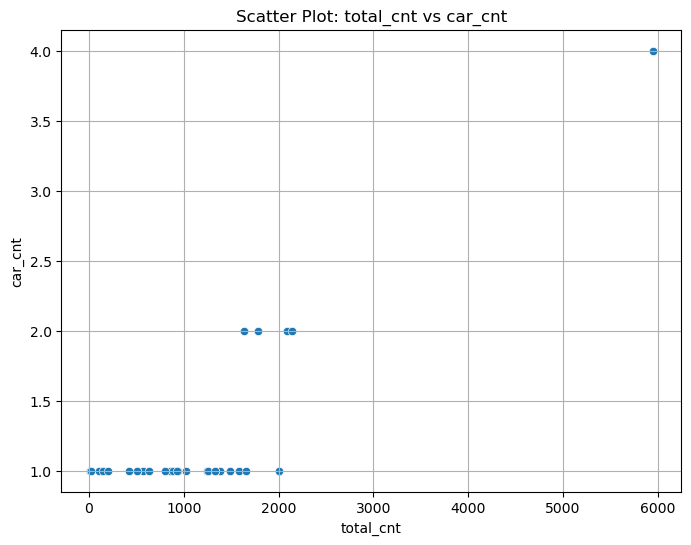

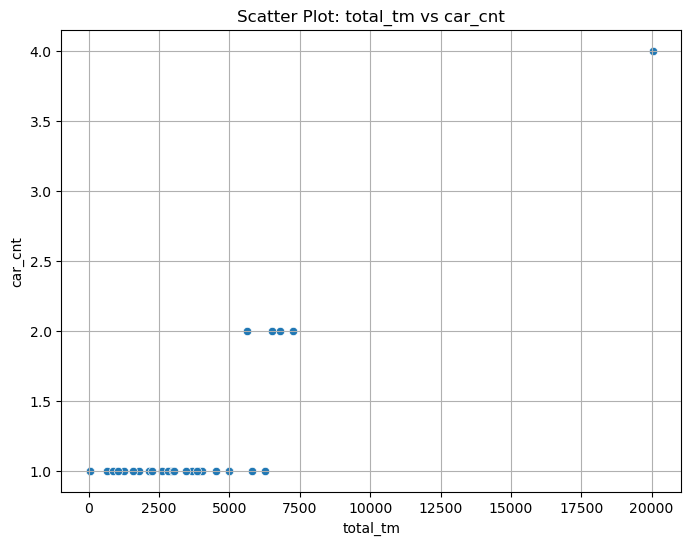

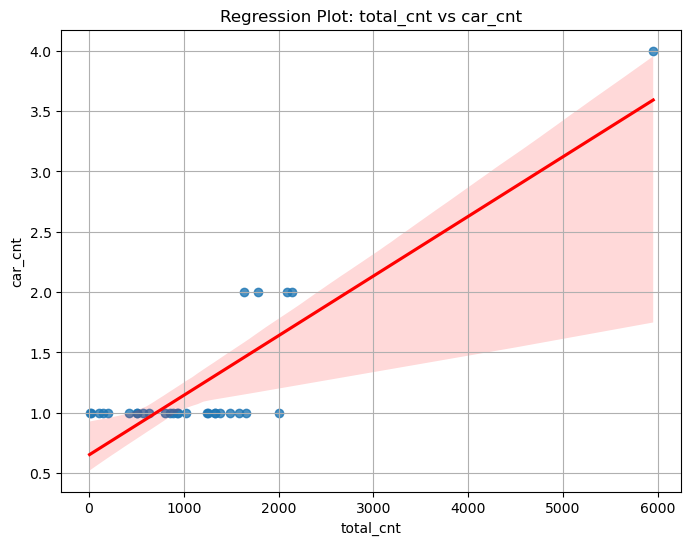

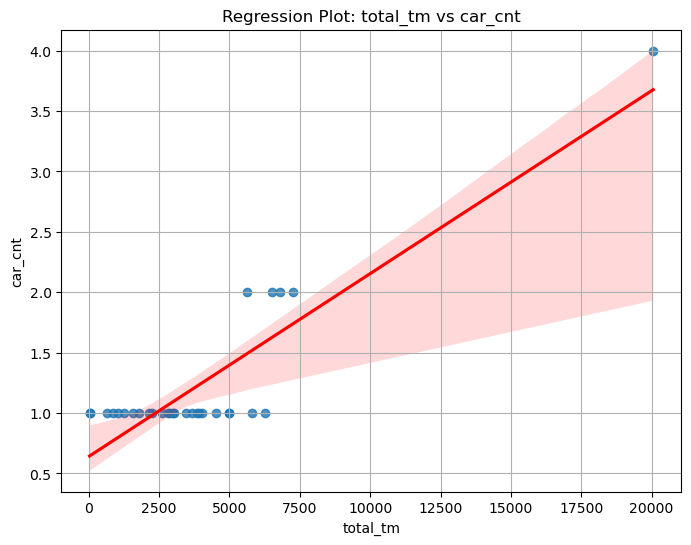

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 세 열이 모두 있는 데이터만 사용
train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])

# 2. 산점도 시각화
# (1) total_cnt와 car_cnt의 관계
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_data['total_cnt'], y=train_data['car_cnt'])
plt.title('Scatter Plot: total_cnt vs car_cnt')
plt.xlabel('total_cnt')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

# (2) total_tm와 car_cnt의 관계
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_data['total_tm'], y=train_data['car_cnt'])
plt.title('Scatter Plot: total_tm vs car_cnt')
plt.xlabel('total_tm')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

# 3. 선형 회귀선을 함께 표시 (선형 관계 확인)
# (1) total_cnt와 car_cnt
plt.figure(figsize=(8, 6))
sns.regplot(x=train_data['total_cnt'], y=train_data['car_cnt'], line_kws={"color": "red"})
plt.title('Regression Plot: total_cnt vs car_cnt')
plt.xlabel('total_cnt')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

# (2) total_tm와 car_cnt
plt.figure(figsize=(8, 6))
sns.regplot(x=train_data['total_tm'], y=train_data['car_cnt'], line_kws={"color": "red"})
plt.title('Regression Plot: total_tm vs car_cnt')
plt.xlabel('total_tm')
plt.ylabel('car_cnt')
plt.grid()
plt.show()


#### 공공주택

In [137]:
sharehouse_df = pd.read_csv('SBJ_2411_001/1-12.공공주택임대_정보(화성시).csv')

# 그룹화 및 처리 함수 정의
def process_matching_rows(group):
    # 첫 번째와 두 번째 열: 같은 값이므로 하나의 값 선택
    col1_value = group.iloc[0, 0]  # 첫 번째 열
    col2_value = group.iloc[0, 1]  # 두 번째 열

    # 세 번째 열: ','로 구분해 값 결합
    col3_combined = ",".join(group.iloc[:, 2].astype(str).unique())  # 세 번째 열

    # 네 번째와 다섯 번째 열: 숫자 합산
    col4_sum = group.iloc[:, 3].sum()  # 네 번째 열
    col5_sum = group.iloc[:, 4].sum()  # 다섯 번째 열

    # 여섯 번째와 일곱 번째 열: 같은 값이므로 하나의 값 선택
    col6_value = group.iloc[0, 5]  # 여섯 번째 열
    col7_value = group.iloc[0, 6]  # 일곱 번째 열

    return pd.Series([col1_value, col2_value, col3_combined, col4_sum, col5_sum, col6_value, col7_value])

# sharehouse_df를 blck_cd 기준으로 그룹화하고 처리
processed_sharehouse = (
    sharehouse_df.groupby("blck_cd").apply(process_matching_rows)
)

# 열 이름 재설정
processed_sharehouse.columns = [
    "col1_value", "col2_value", "col3_combined", "col4_sum", "col5_sum", "col6_value", "col7_value"
]

# sharecar_df와 병합
merged_df = pd.merge(sharecar_df, processed_sharehouse, on="blck_cd", how="left")
merged_df = merged_df.iloc[:,2:]
new_column_names = sharehouse_df.columns
merged_df.columns = list(merged_df.columns[:-7]) + list(new_column_names)
merged_df = geo_transform(merged_df)
last_8_columns = merged_df.columns[-8:]
remaining_columns = merged_df.columns[:-8]
merged_df = merged_df[list(last_8_columns) + list(remaining_columns)]
merged_df['parking_slot'] = merged_df['parking_slot'].astype(int)
merged_df = merged_df.drop(columns=['lon', 'lat'])
merged_gdf = merged_df.reset_index(drop=True)
grid_map_gdf = grid_map_df.reset_index(drop=True)
joined_gdf = gpd.sjoin(merged_df, grid_map_df, how='left', op='within')
joined_gdf['geometry'] = joined_gdf['properties.gid'].map(grid_dict)
target_column = joined_gdf.columns[-2]
columns = list(joined_gdf.columns)
columns.remove(target_column)
columns.insert(5, target_column)
joined_gdf = joined_gdf[columns]
joined_gdf = joined_gdf.iloc[:,:-3]

100%|██████████| 30/30 [00:00<00:00, 9566.57it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [172]:
joined_gdf

,blck_cd,blck_nm,type_left,noh,parking_slot,properties.gid,geometry,car_type,car_cnt,cnt_2008,tm_2008,cnt_2009,tm_2009,cnt_2010,tm_2010,cnt_2011,tm_2011,cnt_2012,tm_2012,cnt_2101,tm_2101,cnt_2102,tm_2102,cnt_2103,tm_2103,cnt_2104,tm_2104,cnt_2105,tm_2105,cnt_2106,tm_2106,cnt_2107,tm_2107,cnt_2108,tm_2108,cnt_2109,tm_2109,cnt_2110,tm_2110,cnt_2111,tm_2111,cnt_2112,tm_2112,cnt_2201,tm_2201,cnt_2202,tm_2202,cnt_2203,tm_2203,cnt_2204,tm_2204,cnt_2205,tm_2205,cnt_2206,tm_2206,cnt_2207,tm_2207,cnt_2208,tm_2208,cnt_2209,tm_2209,cnt_2210,tm_2210,cnt_2211,tm_2211,cnt_2212,tm_2212,cnt_2301,tm_2301,cnt_2302,tm_2302,cnt_2303,tm_2303,cnt_2304,tm_2304,cnt_2305,tm_2305,cnt_2306,tm_2306,cnt_2307,tm_2307,cnt_2308,tm_2308,cnt_2309,tm_2309,cnt_2310,tm_2310,cnt_2311,tm_2311,cnt_2312,tm_2312,total_cnt,total_tm
0,C02347,"화성남양뉴타운(LH10단지)(국임,임대상가)",국민임대,1022,1533,다사409122,"POLYGON ((126.83397 37.20674, 126.83397 37.207...",모닝어반,1,41,152,42,181,26,82,35,58,21,61,13,34,18,125,20,62,13,73,16,99,10,87,18,80,14,49,20,65,28,87,38,114,30,69,31,109,26,79,23,56,24,47,23,75,31,88,32,63,20,59,22,63,25,62,18,42,24,84,14,32,12,27,10,14,19,73,16,147,18,68,14,68,9,42,18,35,15,25,9,21,8,29,855,2888
1,C01961,화성남양뉴타운(LH4단지)(국임),국민임대,876,1314,다사405125,"POLYGON ((126.82944 37.20942, 126.82943 37.210...",,1,25,224,6,43,1,6,2,2,2,5,2,3,3,4,4,21,4,4,7,25,9,31,9,35,5,91,6,46,10,42,9,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,645
2,C02042,화성남양뉴타운(LH9단지)(국임),국민임대,782,1173,다사408124,"POLYGON ((126.83283 37.20854, 126.83282 37.209...",,1,11,82,13,20,22,17,36,50,39,46,41,34,35,61,27,66,19,52,12,18,8,10,17,43,18,59,25,69,28,55,23,88,38,103,59,201,47,109,40,83,39,125,47,99,49,150,24,64,10,68,30,57,8,41,16,47,13,46,13,20,12,22,17,29,16,26,9,17,11,30,11,35,6,9,0,0,0,0,0,0,0,0,889,2151
3,C01569,화성동탄7-2(1-5)(7단지 능동),국민임대,963,1444,다사610125,"POLYGON ((127.06047 37.21050, 127.06046 37.211...",더뉴레이,1,45,142,44,117,63,263,39,113,34,191,26,83,46,87,23,81,37,155,31,142,25,90,33,113,36,157,24,85,28,155,16,103,41,89,47,205,32,75,41,74,25,119,38,92,35,67,32,121,27,57,30,81,27,59,43,75,41,105,40,78,29,54,37,67,36,52,34,51,28,46,40,52,42,55,32,45,23,37,25,29,27,50,1377,3912
4,C02333,화성동탄2 A82블럭(28단지)(행복),행복주택,816,1224,다사640072,"POLYGON ((127.09453 37.16285, 127.09453 37.163...",더뉴레이/올뉴모닝,2,55,128,63,169,45,102,47,133,48,111,50,157,51,172,70,175,79,211,66,188,68,224,65,263,81,259,81,258,76,239,62,247,74,225,58,192,53,126,46,149,43,167,74,252,46,207,42,123,41,163,37,208,48,195,41,210,30,110,40,162,43,156,48,96,60,99,33,84,35,63,32,78,39,78,49,114,26,54,41,93,45,74,2090,6514
5,C01890,화성동탄2 A65블럭(26단지 레이크빌),공공임대,754,1131,다사648086,"POLYGON ((127.10348 37.17550, 127.10347 37.176...",올뉴모닝,1,13,26,19,44,22,122,14,41,18,36,19,46,28,69,22,52,21,50,20,118,38,151,30,129,58,92,35,96,43,150,49,131,37,66,31,76,27,64,26,79,30,62,24,58,18,60,30,130,21,45,18,84,14,49,18,58,22,60,15,34,18,44,25,44,26,57,20,24,18,36,19,48,12,27,11,9,8,21,4,3,0,0,937,2590
6,C02014,(NHF제3호)화성동탄2 A50블럭(22단지 르파비스),공공임대,876,1314,다사668095,"POLYGON ((127.12597 37.18369, 127.12596 37.184...",올뉴K3,1,31,125,25,85,39,119,36,102,36,73,34,96,32,112,46,113,48,155,34,184,47,123,36,145,40,116,34,171,45,150,48,132,44,125,35,180,50,142,33,111,35,149,37,187,42,196,51,190,43,305,42,216,41,138,42,102,27,53,35,116,29,55,42,73,38,105,32,119,26,56,39,44,34,126,38,97,27,37,30,35,13,16,1486,4975
7,C02015,(NHF제3호)화성동탄2 A69블럭(24단지 스타힐스),공공임대,882,1323,다사661083,"POLYGON ((127.11813 37.17284, 127.11813 37.173...",더뉴레이,1,26,165,31,90,24,91,29,138,31,75,27,129,21,62,29,90,40,118,54,126,56,137,78,140,45,99,43,171,55,139,55,161,64,154,47,135,52,133,37,99,34,91,41,99,31,117,43,99,29,76,32,112,36,62,40,75,37,126,43,82,34,87,59,65,51,108,47,79,29,29,24,46,30,32,36,48,30,35,17,28,31,62,1581,4013
8,C02329,(NHF제12호)화성동탄2 A63블럭(23단지 센트럴써밋),공공임대,740,1110,다사665086,"POLYGON ((127.12263 37.17556, 127.12262 37.176...",더뉴레이,1,0,0,0,0,0,0,5,16,22,54,24,78,25,86,28,95,19,76,25,80,21,68,30,79,32,80,42,103,43,242,39,123,3

In [ ]:
# 맵 객체 생성 및 데이터 로드
hwasung_share_map = KeplerGl(height=1000, width=1500)
hwasung_share_map.add_data(data=joined_gdf, name="공유차량 병합 데이터")
hwasung_share_map.add_data(data=hwasung_gdf, name="화성시 행정동 데이터")

hwasung_share_map